# Análisis de posibles Insights del estudio a realizar

### Importamos las librerias correspondientes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Importamos los datasets a estudiar

In [2]:
dfe_2023=pd.read_csv("../input/db/sales/electro-2023.csv", parse_dates=["Date"])
dfe_2024=pd.read_csv("../input/db/sales/electro-2024.csv",parse_dates=["Date"])
dfe_2025=pd.read_csv("../input/db/sales/electro-2025.csv",parse_dates=["Date"])
dfm_2023=pd.read_csv("../input/db/sales/mascotas-2023.csv", parse_dates=["Date"])
dfm_2024=pd.read_csv("../input/db/sales/mascotas-2024.csv",parse_dates=["Date"])
dfm_2025=pd.read_csv("../input/db/sales/mascotas-2025.csv",parse_dates=["Date"])
locations=pd.read_csv("../output/locations_cleaned.csv")
products=pd.read_csv("../output/Productos.csv")

### Unimos los datasets y tomamos en cuenta solo las ventas

In [3]:
electronics= pd.concat([dfe_2023, dfe_2024, dfe_2025], ignore_index=True)
electronics=electronics[electronics["Type"]=="Sale"]
mascotas= pd.concat([dfm_2023, dfm_2024, dfm_2025], ignore_index=True)
mascotas=mascotas[mascotas["Type"]=="Sale"]

### Unimos los datasets de localización con los de ventas y productos

In [4]:
electronics["venta"]=electronics["TotalPrice"]-electronics["TotalDiscount"]
electronics["ganancia"]=electronics["TotalPrice"]-electronics["venta"]

electronics['Category'] = electronics['ProductId'].map(products.set_index('idProd')['PCategory'])
electronics['SubCategory'] = electronics['ProductId'].map(products.set_index('idProd')['subCat'])
electronics['SectionProduc'] = electronics['ProductId'].map(products.set_index('idProd')['SectionProduc'])
electronics['TipoTienda'] = electronics['LocationStockId'].map(locations.set_index('id')['type'])
electronics['DimensionesTienda'] = electronics['LocationStockId'].map(locations.set_index('id')['tamanio'])
electronics['Ciudad'] = electronics['LocationStockId'].map(locations.set_index('id')['city'])
electronics=electronics[(electronics["SectionProduc"]=="GAMA  BLANCA") |( electronics["Category"]=="COCINA")] #Filtramos solo por electodomesticos

### Generamos nuevas columnas que nos pueden servir en al futuro

In [5]:
mascotas["venta"]=mascotas["TotalPrice"]-mascotas["TotalDiscount"]  #Nueva columna de venta
mascotas["ganancia"]=mascotas["TotalPrice"]-mascotas["venta"] # Nueva columna de ganancia
mascotas['Category'] = mascotas['ProductId'].map(products.set_index('idProd')['PCategory'])
mascotas['SubCategory'] = mascotas['ProductId'].map(products.set_index('idProd')['subCat'])
mascotas['General'] = mascotas['ProductId'].map(products.set_index('idProd')['General'])
mascotas['TipoTienda'] = mascotas['LocationStockId'].map(locations.set_index('id')['type'])
mascotas['DimensionesTienda'] = mascotas['LocationStockId'].map(locations.set_index('id')['tamanio'])
mascotas['Ciudad'] = mascotas['LocationStockId'].map(locations.set_index('id')['city'])
mascotas=mascotas[(mascotas["General"]=="MASCOTAS") ] #Filtramos solo por mascotas

### Realizamos los respectivos agrupamiento por las columnas de interes

In [6]:
df_aggelec = electronics.groupby(['Date', 'LocationId', 'LocationStockId','Category', 'TipoTienda',
       'DimensionesTienda', 'Ciudad'], as_index=False).agg({
    'venta': 'sum',
    'ganancia': 'sum',
    'Quantity': 'sum'
})
df_aggmasc = mascotas.groupby(['Date', 'LocationId', 'LocationStockId','Category', 'TipoTienda',
       'DimensionesTienda', 'Ciudad'], as_index=False).agg({
    'venta': 'sum',
    'ganancia': 'sum',
    'Quantity': 'sum'
})

### Realizamos la serie de tiempo de la venta de electrodomésticos

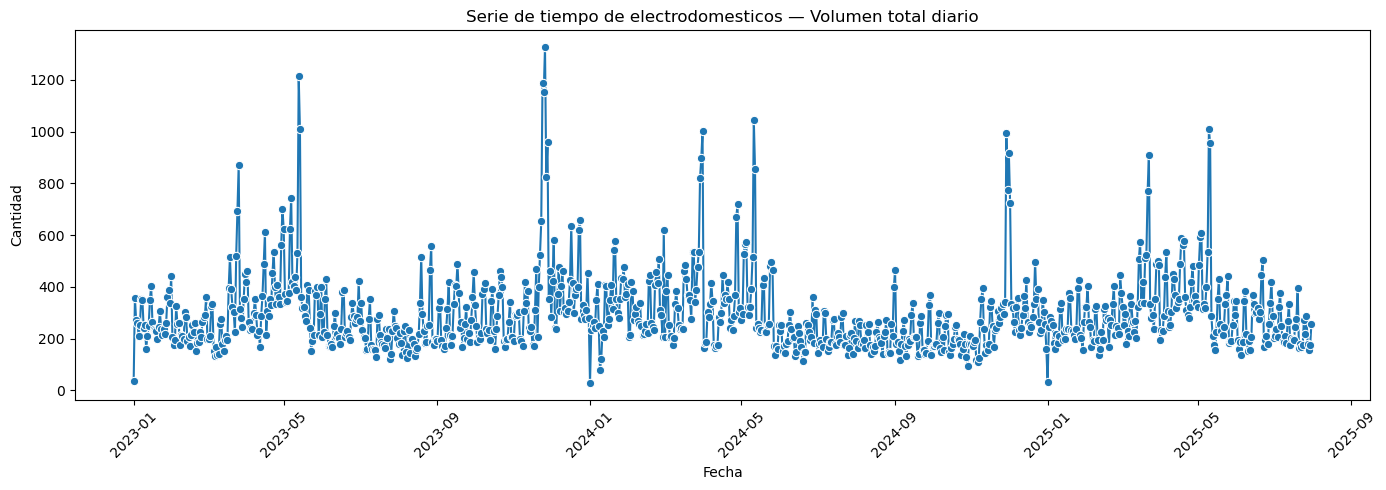

In [7]:
df_aggelec["Date"] = pd.to_datetime(df_aggelec["Date"], errors="coerce")

# 1) Serie de tiempo total (diaria)
serie_total = (
    df_aggelec.groupby("Date", as_index=False)["Quantity"]
              .sum()
              .sort_values("Date")
)

plt.figure(figsize=(14, 5))
sns.lineplot(data=serie_total, x="Date", y="Quantity", marker="o")
plt.title("Serie de tiempo de electrodomesticos — Volumen total diario")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../output/images/elec/serie_tiempo_total.png", bbox_inches="tight")
plt.show()

### Realizamos la serie de tiempo de la venta de productos de mascotas

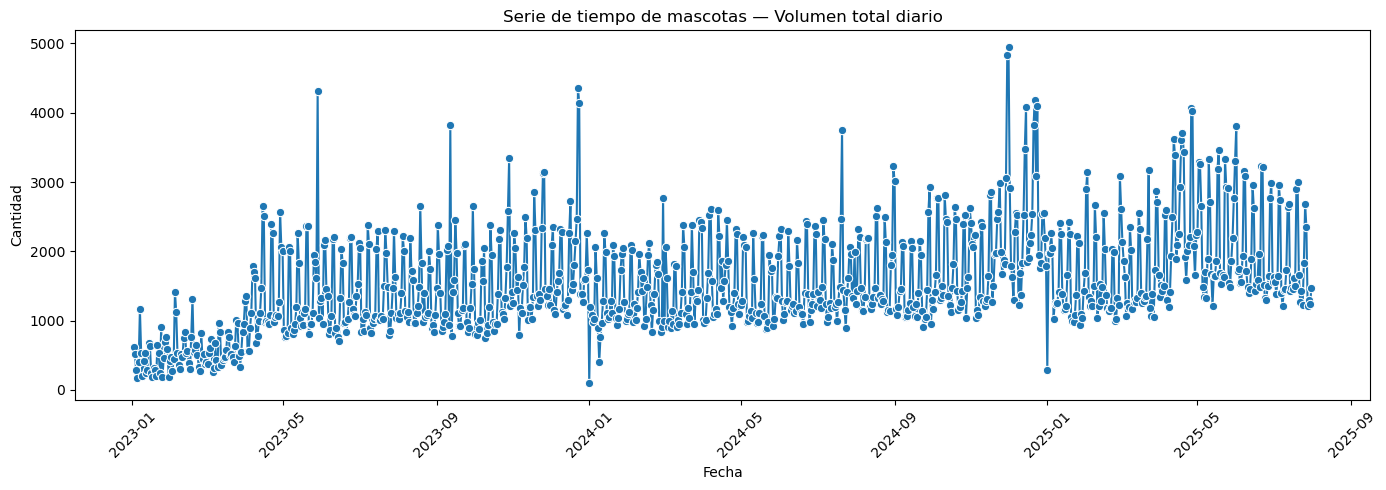

In [8]:
df_aggmasc["Date"] = pd.to_datetime(df_aggmasc["Date"], errors="coerce")

# 1) Serie de tiempo total (diaria)
serie_total = (
    df_aggmasc.groupby("Date", as_index=False)["Quantity"]
              .sum()
              .sort_values("Date")
)

plt.figure(figsize=(14, 5))
sns.lineplot(data=serie_total, x="Date", y="Quantity", marker="o")
plt.title("Serie de tiempo de mascotas — Volumen total diario")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../output/images/mascota/serie_tiempo_total.png", bbox_inches="tight")
plt.show()

### Definimos las variables estacionales

In [9]:
festivos = pd.to_datetime(['2023-01-02', '2023-02-20', '2023-02-21', '2023-04-07','2023-05-01','2023-05-26','2023-08-11','2023-10-09','2023-11-02','2023-11-03','2023-12-25'
                           , '2024-01-01', '2024-02-12', '2024-02-23', '2024-03-29','2024-05-03','2024-05-24','2024-08-09','2024-10-11','2024-11-01','2024-11-04','2024-12-25',
                           '2025-01-01', '2025-03-03', '2025-03-04', '2025-04-18','2025-05-02','2025-05-23','2025-08-11','2025-10-10','2025-11-03','2025-11-04','2025-12-25'])
df_aggelec['es_festivo'] = df_aggelec['Date'].isin(festivos).astype(int) # 1 si es festivo, 0 si no lo es
df_aggelec['dia_semana'] = df_aggelec['Date'].dt.dayofweek # Lunes=0, Domingo=6
df_aggelec['mes'] = df_aggelec['Date'].dt.month # 1-12
# Codificación cíclica semanal
df_aggelec['sin_semana'] = np.sin(2 * np.pi * df_aggelec['dia_semana'] / 7) # Transformación seno
df_aggelec['cos_semana'] = np.cos(2 * np.pi * df_aggelec['dia_semana'] / 7) # Transformación coseno

# Codificación cíclica mensual
df_aggelec['sin_mes'] = np.sin(2 * np.pi * df_aggelec['mes'] / 12) # Transformación seno
df_aggelec['cos_mes'] = np.cos(2 * np.pi * df_aggelec['mes'] / 12) # Transformación coseno

# Rezagos
df_aggelec['ventas_lag1'] = df_aggelec['venta'].shift(1) # Venta del día anterior
df_aggelec['ventas_lag7'] = df_aggelec['venta'].shift(7) # Venta hace una semana
df_aggelec['ventas_rolling7'] = df_aggelec['venta'].shift(1).rolling(window=7).mean() # Media móvil de 7 días

df_aggelec = df_aggelec.dropna().reset_index(drop=True)
df_aggelec.dropna(inplace=True)

In [10]:
df_aggmasc['es_festivo'] = df_aggmasc['Date'].isin(festivos).astype(int) # 1 si es festivo, 0 si no lo es
df_aggmasc['dia_semana'] = df_aggmasc['Date'].dt.dayofweek # Lunes=0, Domingo=6
df_aggmasc['mes'] = df_aggmasc['Date'].dt.month # 1-12
# Codificación cíclica semanal
df_aggmasc['sin_semana'] = np.sin(2 * np.pi * df_aggmasc['dia_semana'] / 7) # Transformación seno
df_aggmasc['cos_semana'] = np.cos(2 * np.pi * df_aggmasc['dia_semana'] / 7) # Transformación coseno

# Codificación cíclica mensual
df_aggmasc['sin_mes'] = np.sin(2 * np.pi * df_aggmasc['mes'] / 12)  # Transformación seno
df_aggmasc['cos_mes'] = np.cos(2 * np.pi * df_aggmasc['mes'] / 12) # Transformación coseno

# Rezagos
df_aggmasc['ventas_lag1'] = df_aggmasc['Quantity'].shift(1) # Venta del día anterior
df_aggmasc['ventas_lag7'] = df_aggmasc['Quantity'].shift(7) # Venta hace una semana
df_aggmasc['ventas_rolling7'] = df_aggmasc['Quantity'].shift(1).rolling(window=7).mean() # Media móvil de 7 días
df_aggmasc = df_aggmasc.dropna().reset_index(drop=True)
df_aggmasc.dropna(inplace=True)

### Creación de gráficas de interes

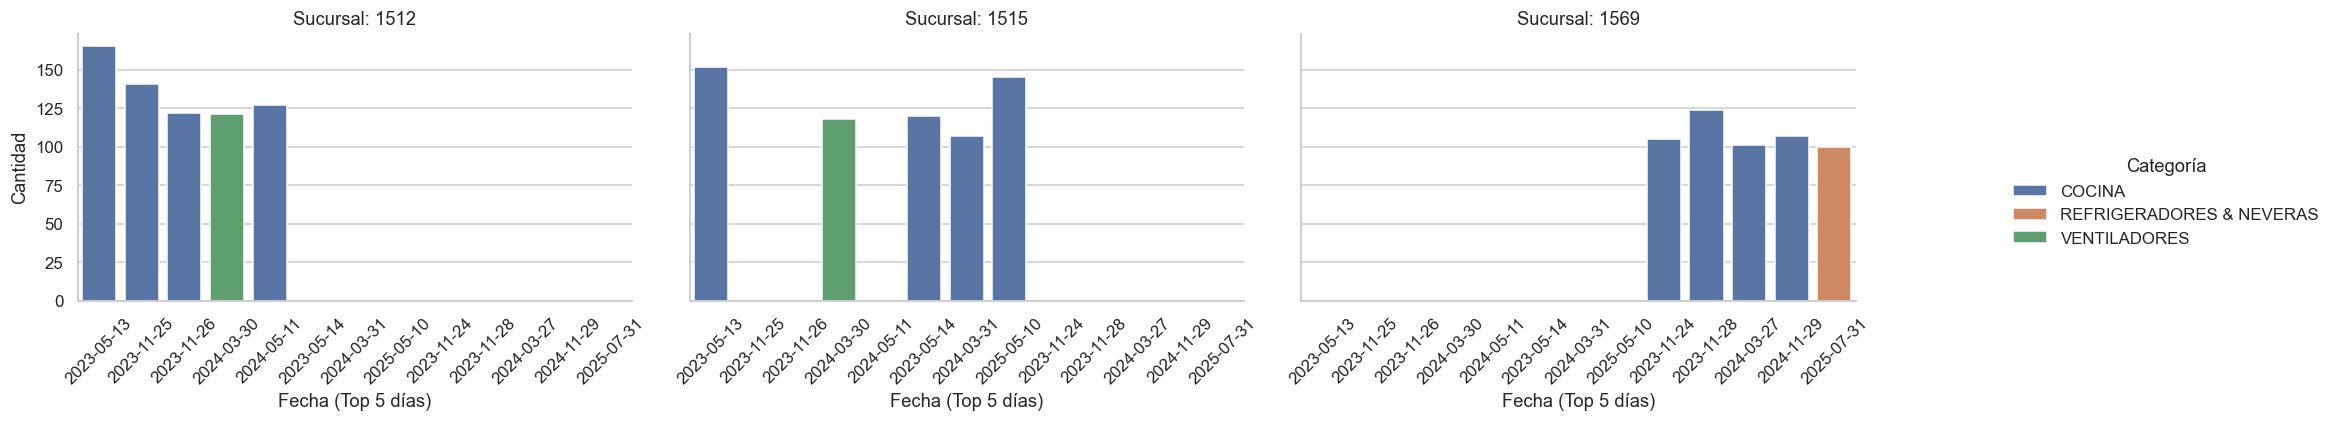

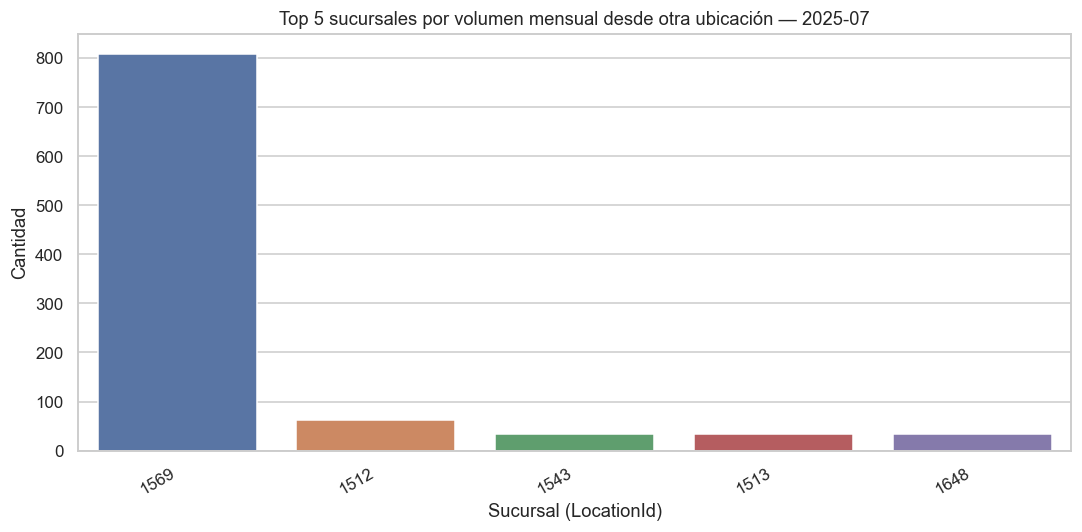

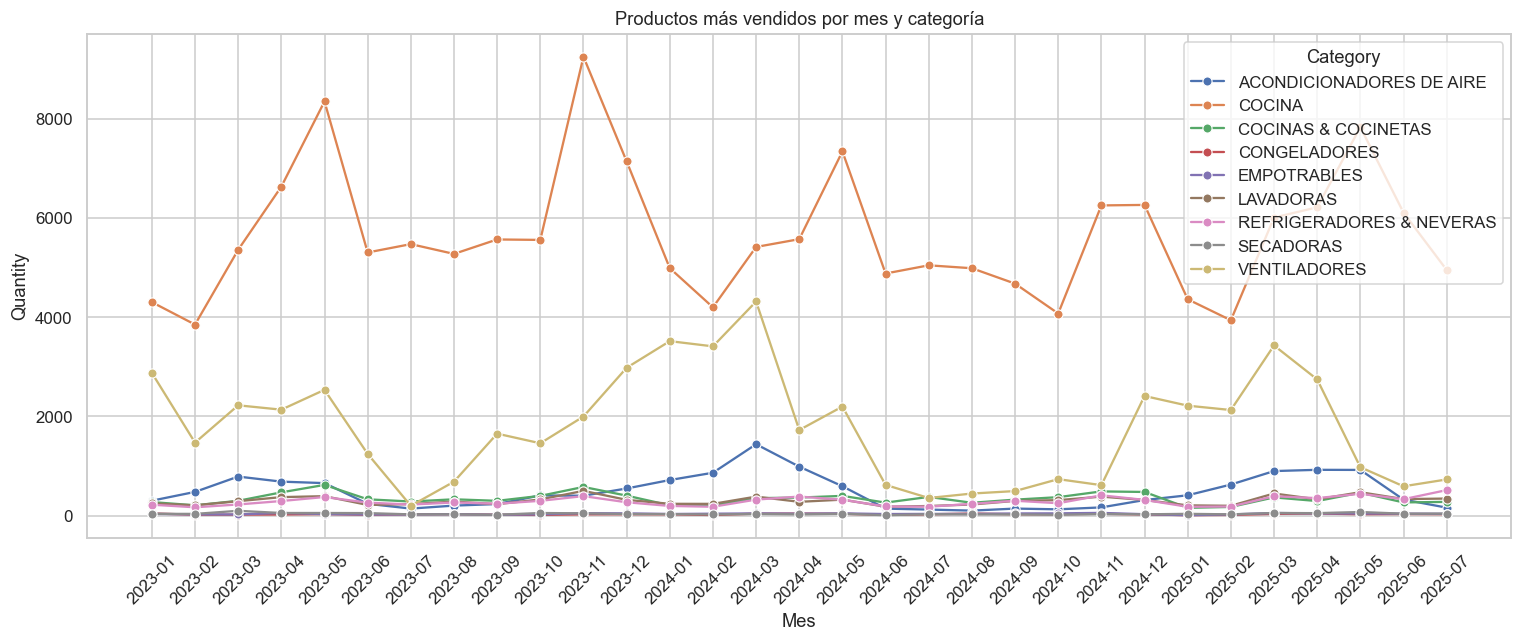

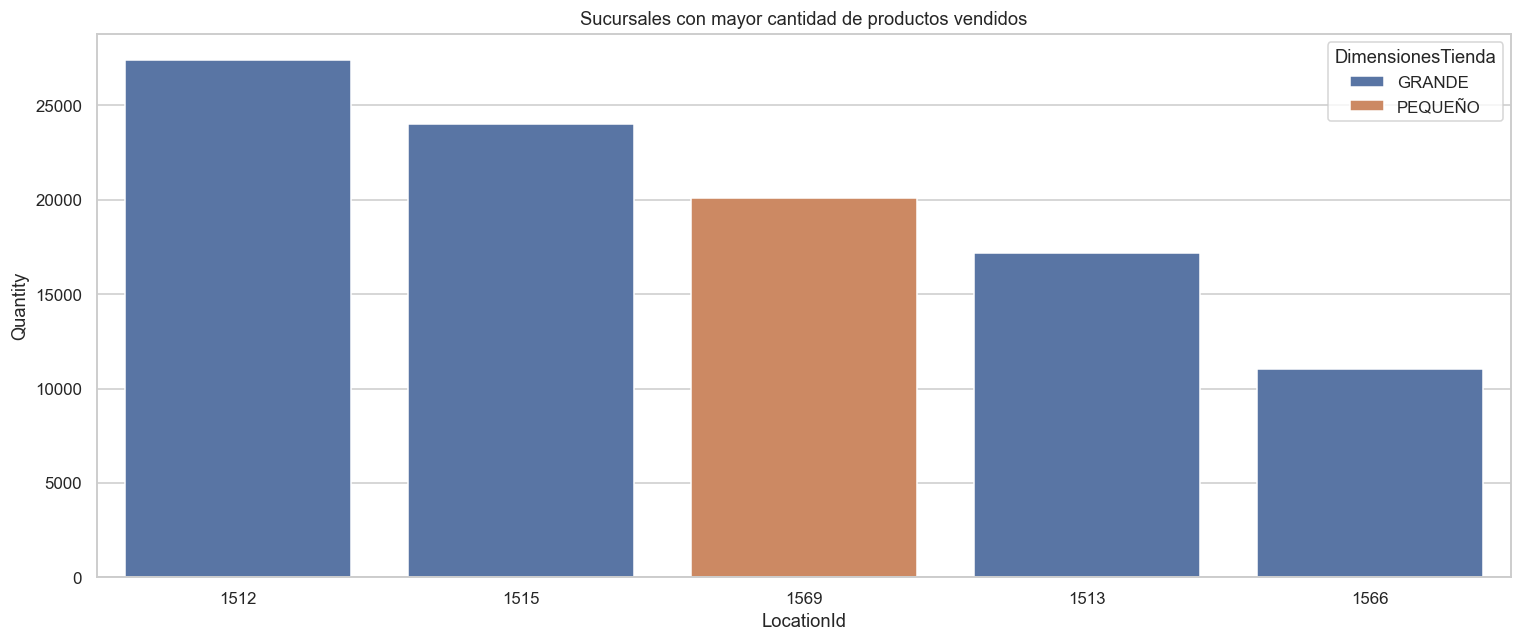

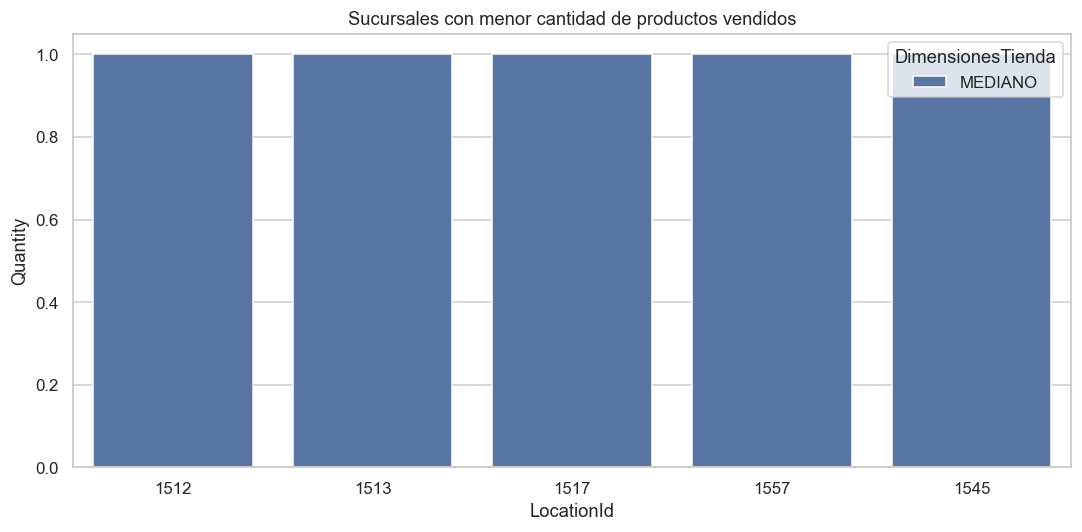

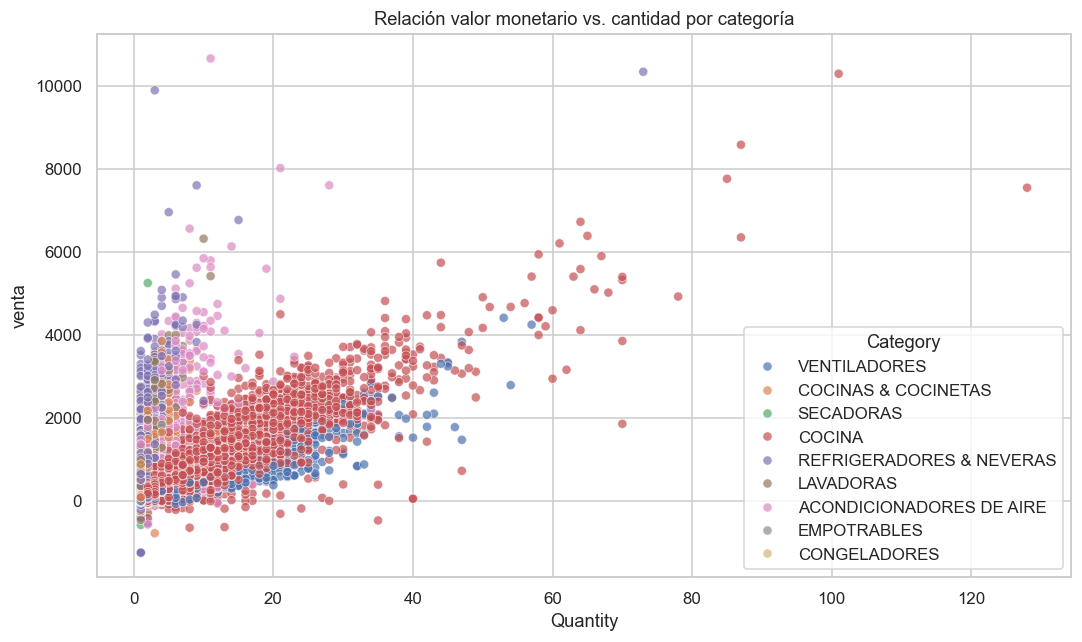

In [11]:
# Configuración de estilo
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 110




# Normalización 
df_aggelec["LocationId"] = df_aggelec["LocationId"].astype(str)
df_aggelec["LocationStockId"] = df_aggelec["LocationStockId"].astype(str)
df_aggelec["Mes"] = df_aggelec["Date"].dt.to_period("M").astype(str)

# ==========================================
# 1) Top 5 productos más vendidos por día
# ==========================================
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 110


# Nos aseguramos de que Date sea datetime
df_aggelec["Date"] = pd.to_datetime(df_aggelec["Date"], errors="coerce")

#  Top 3 sucursales por venta total 
top3_suc = (
    df_aggelec.groupby("LocationId", as_index=False)["Quantity"].sum()
    .sort_values("Quantity", ascending=False)
    .head(3)["LocationId"].tolist()
)
df_top3 = df_aggelec[df_aggelec["LocationId"].isin(top3_suc)].copy()

# Totales diarios por sucursal
daily_total = (
    df_top3.groupby(["LocationId", "Date"], as_index=False)["Quantity"].sum()
    .rename(columns={"Quantity": "Quantity_total"})
)

# Categoría dominante (la de mayor cantidad) por sucursal y día
daily_by_cat = (
    df_top3.groupby(["LocationId", "Date", "Category"], as_index=False)["Quantity"].sum()
)
idx_max = (
    daily_by_cat.sort_values(["LocationId", "Date", "Quantity"], ascending=[True, True, False])
    .groupby(["LocationId", "Date"], as_index=False)
    .head(1)  # fila con mayor Quantity -> categoría dominante
    .rename(columns={"Category": "DominantCategory"})
)

# Seleccionamos los 5 días top por sucursal 
top5_days_per_store = (
    daily_total.sort_values(["LocationId", "Quantity_total"], ascending=[True, False])
    .groupby("LocationId", as_index=False)
    .head(5)
)

# Unimos todo total + categoría dominante y realizamos el grafico final
plot_df = (
    top5_days_per_store
    .merge(idx_max[["LocationId", "Date", "DominantCategory"]], on=["LocationId", "Date"], how="left")
    .copy()
)
plot_df["Date_str"] = plot_df["Date"].dt.strftime("%Y-%m-%d")

# Orden estable de sucursales y categorías
store_order = list(plot_df["LocationId"].unique())
cat_order = sorted(plot_df["DominantCategory"].dropna().unique())

plot_df["LocationId"] = pd.Categorical(plot_df["LocationId"], categories=store_order, ordered=True)
plot_df["DominantCategory"] = pd.Categorical(plot_df["DominantCategory"], categories=cat_order, ordered=True)

#  3 facetas (una por sucursal), x = fecha, color = categoría dominante 
g = sns.catplot(
    data=plot_df.sort_values(["LocationId", "Date"]), 
    kind="bar",
    col="LocationId", col_order=store_order,  # facetas por sucursal
    x="Date_str", y="Quantity_total",
    hue="DominantCategory", hue_order=cat_order,  # color = categoría
    dodge=False, height=4, aspect=1.2,
    legend=True
)

g.set_axis_labels("Fecha (Top 5 días)", "Cantidad") 
g.set_titles("Sucursal: {col_name}")
g._legend.set_title("Categoría")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_loc('center left')
g._legend.set_title("Categoría")

plt.tight_layout()
plt.savefig("../output/images/elec/top5_dias_top3_sucursales_color_categoria.png", bbox_inches="tight")
plt.show()



# ==========================================
# 2) Sucursales con mayor volumen desde otra ubicación
# ==========================================
df_aggelec["Date"] = pd.to_datetime(df_aggelec["Date"], errors="coerce")

# Filtramos transferencias (ventas desde otra ubicación)
xfer = df_aggelec[df_aggelec["LocationId"] != df_aggelec["LocationStockId"]].copy()

#  Mes (YYYY-MM)
xfer["Mes"] = xfer["Date"].dt.to_period("M").astype(str)

# Agregamos por mes y sucursal
mensual = (
    xfer.groupby(["Mes", "LocationId"], as_index=False)["Quantity"]
        .sum()
)

# Tomamos el mes más reciente con datos
ultimo_mes = mensual["Mes"].max()

# Top 5 sucursales de ese mes
mensual_mes = mensual[mensual["Mes"] == ultimo_mes].copy()
top5 = (
    mensual_mes.sort_values("Quantity", ascending=False)
               .head(5)
)
x_order = top5.sort_values("Quantity", ascending=False)["LocationId"].tolist()

# Graficamos
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=top5,
    x="LocationId", y="Quantity",hue="LocationId",
    order=x_order
)
plt.title(f"Top 5 sucursales por volumen mensual desde otra ubicación — {ultimo_mes}")
plt.xlabel("Sucursal (LocationId)")
plt.ylabel("Cantidad")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("../output/images/elec/sucursales_mayor_volumen_mensual.png", bbox_inches="tight")
plt.show()




# ==========================================
# 3) Productos más vendidos por mes y categoría
# ==========================================
mes_cat = (
    df_aggelec.groupby(["Mes", "Category"])["Quantity"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(data=mes_cat, x="Mes", y="Quantity", hue="Category", marker="o")
plt.title("Productos más vendidos por mes y categoría")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../output/images/elec/productos_mes_categoria.png", bbox_inches="tight")
plt.show()




# ==========================================
# 4) Sucursales con mayor cantidad de productos vendidos
# ==========================================
ventas_sucursal = (
    df_aggelec.groupby(["LocationId", "DimensionesTienda"])["Quantity"]
    .sum()
    .reset_index()
    .sort_values("Quantity", ascending=False)
)
top5 = (
    ventas_sucursal.sort_values("Quantity", ascending=False)
               .head(5)
)
x_order = top5.sort_values("Quantity", ascending=False)["LocationId"].tolist()

plt.figure(figsize=(14,6))
sns.barplot(data=top5, x="LocationId", y="Quantity", hue="DimensionesTienda", order=x_order)
plt.title("Sucursales con mayor cantidad de productos vendidos")
plt.tight_layout()
plt.savefig("../output/images/elec/sucursales_mayor_ventas.png", bbox_inches="tight")
plt.show()





# ==========================================
# 5) Sucursales con menor cantidad de productos vendidos
# ==========================================
min_ventas = ventas_sucursal.nsmallest(5, "Quantity")

plt.figure(figsize=(10,5))
sns.barplot(data=min_ventas, x="LocationId", y="Quantity", hue="DimensionesTienda")
plt.title("Sucursales con menor cantidad de productos vendidos")
plt.tight_layout()
plt.savefig("../output/images/elec/sucursales_menor_ventas.png", bbox_inches="tight")
plt.show()





# ==========================================
# 6) Relación valor monetario vs cantidad
# ==========================================
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_aggelec, x="Quantity", y="venta", hue="Category", alpha=0.7)
plt.title("Relación valor monetario vs. cantidad por categoría")
plt.tight_layout()
plt.savefig("../output/images/elec/relacion_valor_cantidad.png", bbox_inches="tight")
plt.show()


### Realizamos las misma graficas para el sector de mascotas

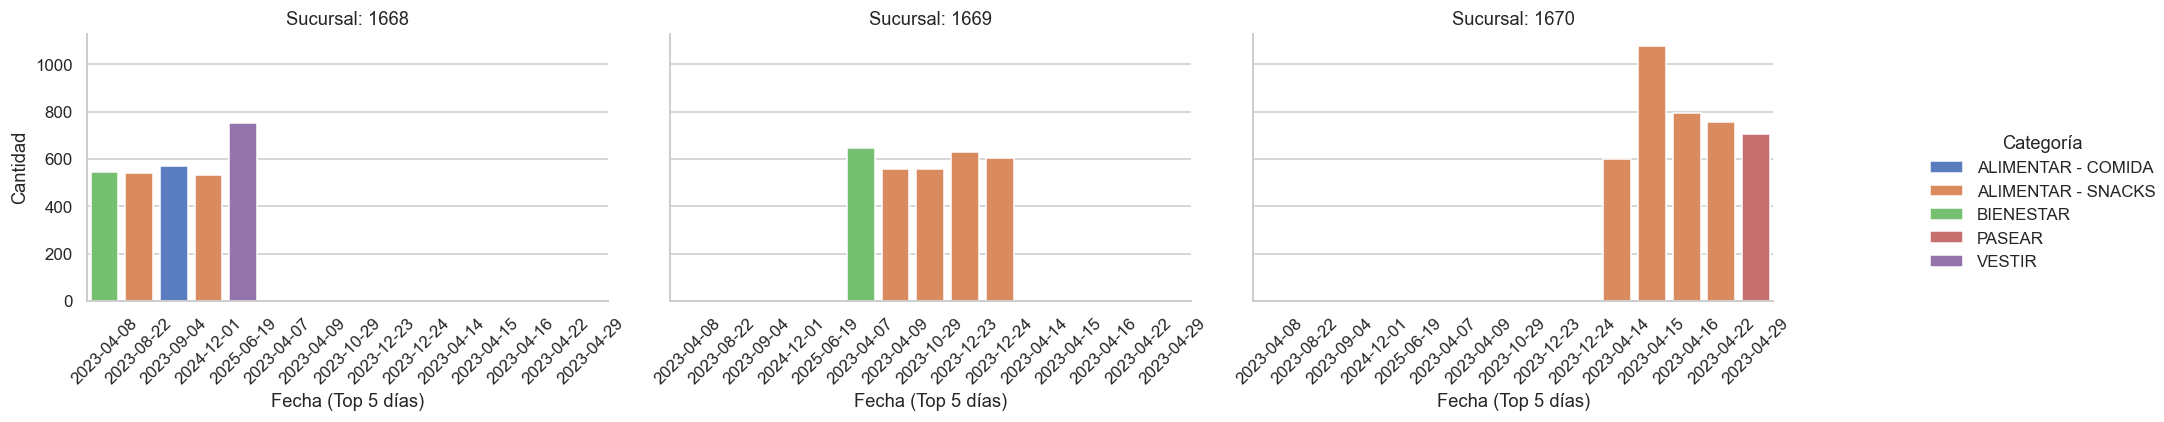

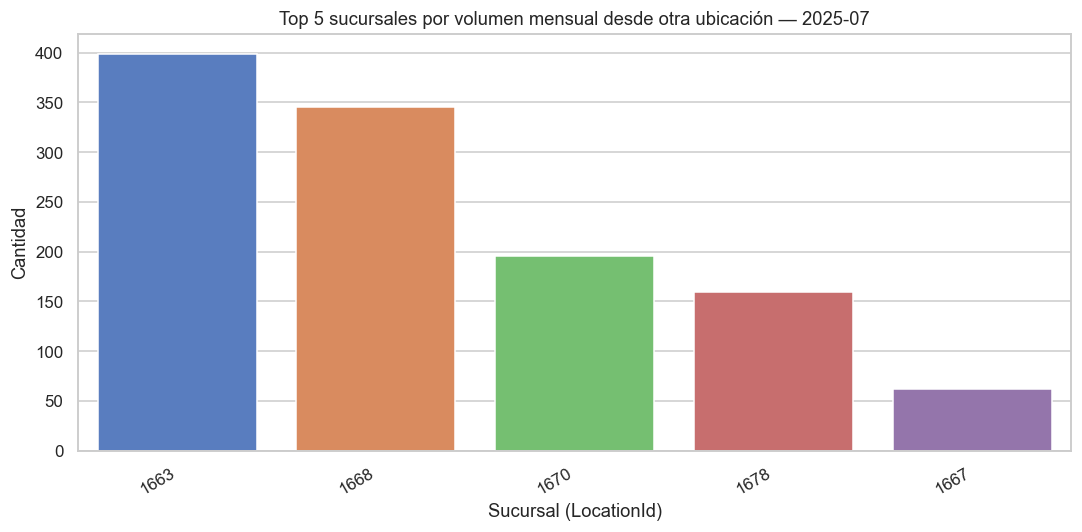

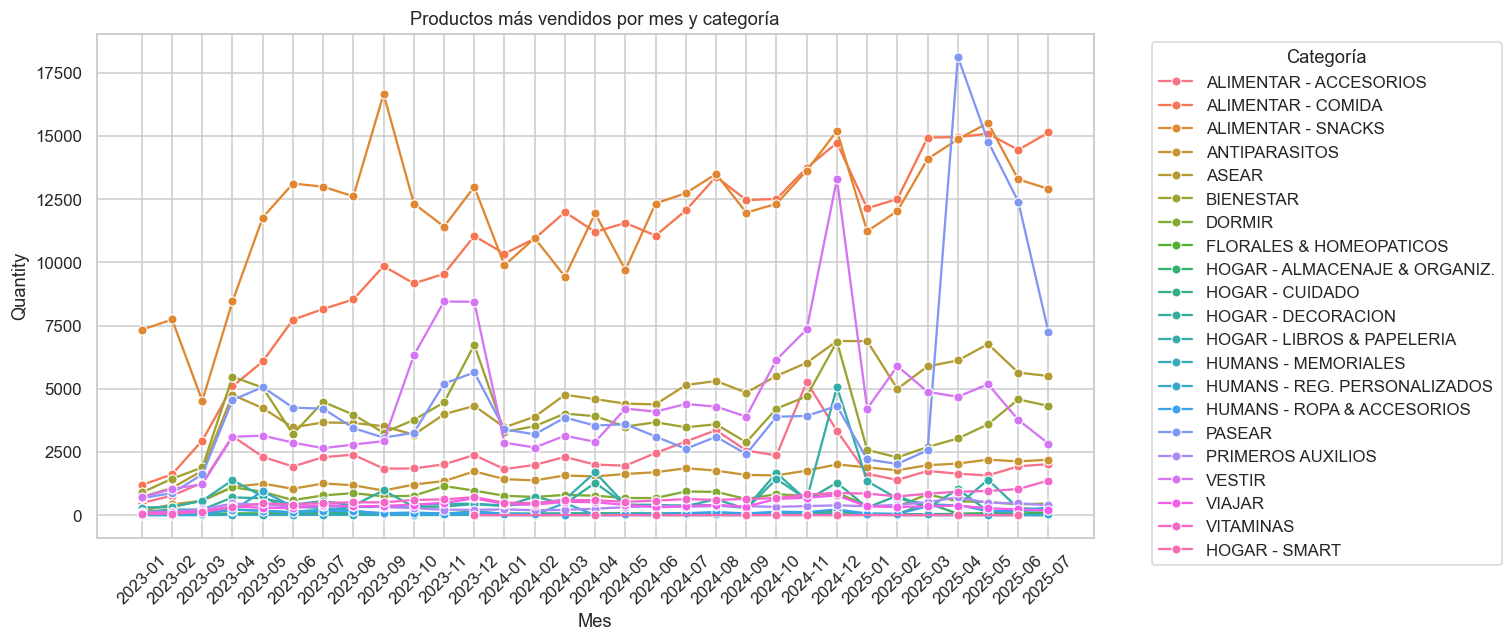

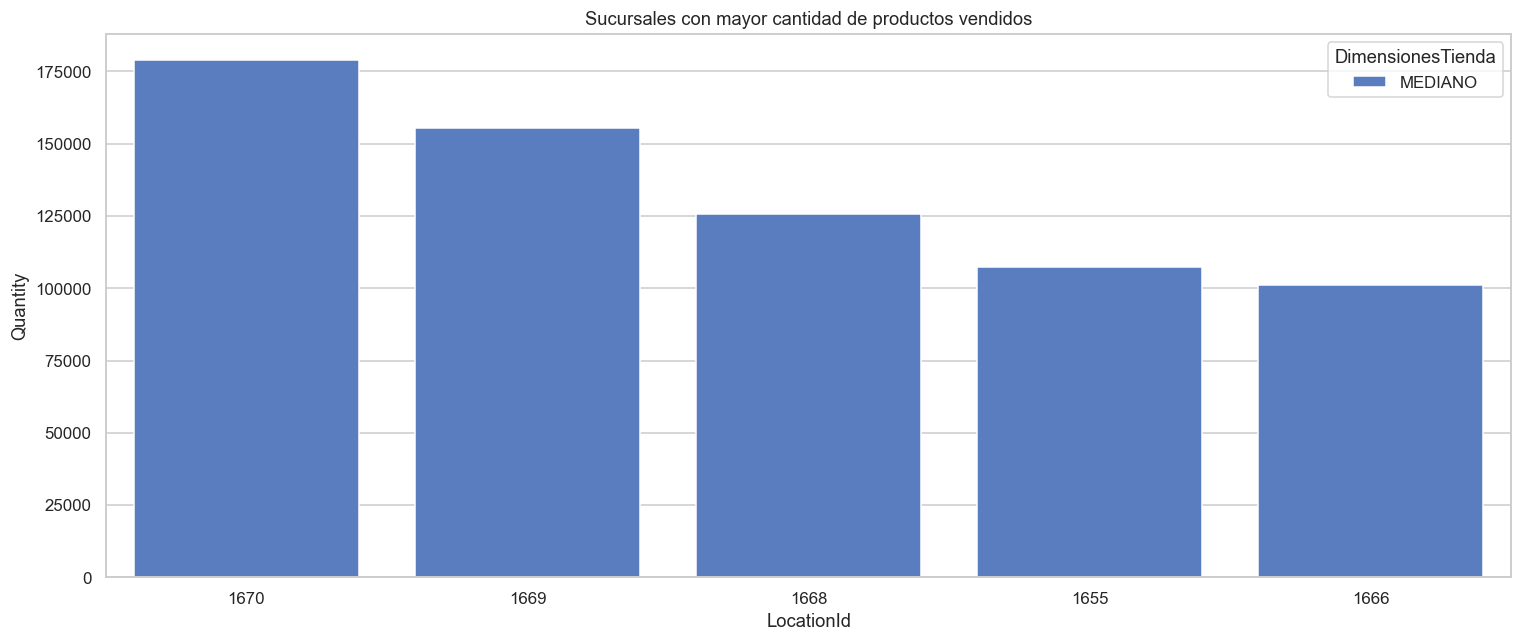

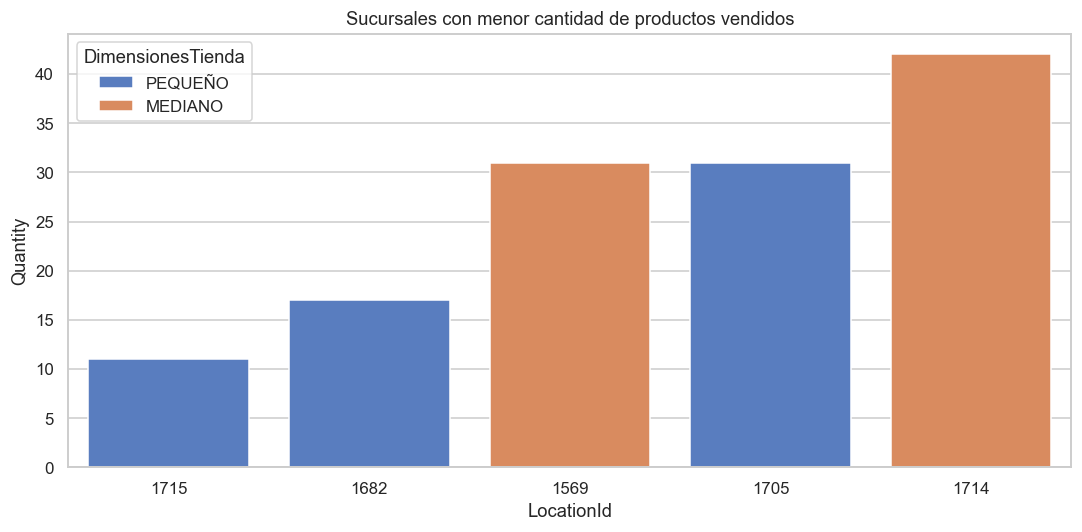

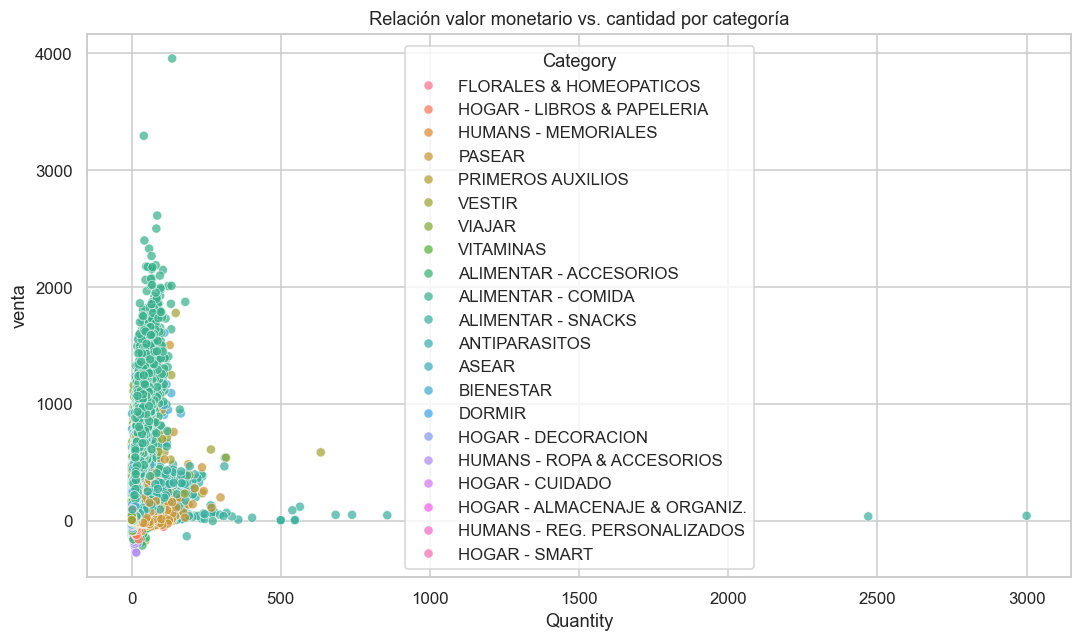

In [12]:
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 110




# Normalización
df_aggmasc["LocationId"] = df_aggmasc["LocationId"].astype(str)
df_aggmasc["LocationStockId"] = df_aggmasc["LocationStockId"].astype(str)
df_aggmasc["Mes"] = df_aggmasc["Date"].dt.to_period("M").astype(str)

# ==========================================
# 1) Top 5 productos más vendidos por día
# ==========================================


# Nos aseguramos de que Date sea datetime
df_aggmasc["Date"] = pd.to_datetime(df_aggmasc["Date"], errors="coerce")

# Top 3 sucursales por venta total 
top3_suc = (
    df_aggmasc.groupby("LocationId", as_index=False)["Quantity"].sum()
    .sort_values("Quantity", ascending=False)
    .head(3)["LocationId"].tolist()
)
df_top3 = df_aggmasc[df_aggmasc["LocationId"].isin(top3_suc)].copy()

# Totales diarios por sucursal
daily_total = (
    df_top3.groupby(["LocationId", "Date"], as_index=False)["Quantity"].sum()
    .rename(columns={"Quantity": "Quantity_total"})
)

# Categoría dominante (la de mayor cantidad) por sucursal y día
daily_by_cat = (
    df_top3.groupby(["LocationId", "Date", "Category"], as_index=False)["Quantity"].sum()
)
idx_max = (
    daily_by_cat.sort_values(["LocationId", "Date", "Quantity"], ascending=[True, True, False])
    .groupby(["LocationId", "Date"], as_index=False)
    .head(1)  # fila con mayor Quantity -> categoría dominante
    .rename(columns={"Category": "DominantCategory"})
)

# Seleccionamos los 5 días top por sucursal (según total)
top5_days_per_store = (
    daily_total.sort_values(["LocationId", "Quantity_total"], ascending=[True, False])
    .groupby("LocationId", as_index=False)
    .head(5)
)

# Unimos todo total + categoría dominante 
plot_df = (
    top5_days_per_store
    .merge(idx_max[["LocationId", "Date", "DominantCategory"]], on=["LocationId", "Date"], how="left")
    .copy()
)
plot_df["Date_str"] = plot_df["Date"].dt.strftime("%Y-%m-%d")

# Orden estable de sucursales y categorías
store_order = list(plot_df["LocationId"].unique())
cat_order = sorted(plot_df["DominantCategory"].dropna().unique())

plot_df["LocationId"] = pd.Categorical(plot_df["LocationId"], categories=store_order, ordered=True)
plot_df["DominantCategory"] = pd.Categorical(plot_df["DominantCategory"], categories=cat_order, ordered=True)

# Grafico
g = sns.catplot(
    data=plot_df.sort_values(["LocationId", "Date"]), 
    kind="bar",
    col="LocationId", col_order=store_order,  # facetas por sucursal
    x="Date_str", y="Quantity_total",
    hue="DominantCategory", hue_order=cat_order,  # color = categoría
    dodge=False, height=4, aspect=1.2,
    legend=True
)

g.set_axis_labels("Fecha (Top 5 días)", "Cantidad")
g.set_titles("Sucursal: {col_name}")
g._legend.set_title("Categoría")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_loc('center left')
g._legend.set_title("Categoría")

plt.tight_layout()
plt.savefig("../output/images/mascota/top5_dias_top3_sucursales_color_categoria.png", bbox_inches="tight")
plt.show()





# ==========================================
# 2) Sucursales con mayor volumen desde otra ubicación
# ==========================================
df_aggmasc["Date"] = pd.to_datetime(df_aggmasc["Date"], errors="coerce")

# Filtramostransferencias (ventas desde otra ubicación)
xfer = df_aggmasc[df_aggmasc["LocationId"] != df_aggmasc["LocationStockId"]].copy()

# Mes (YYYY-MM)
xfer["Mes"] = xfer["Date"].dt.to_period("M").astype(str)

# Agregamos por mes y sucursal
mensual = (
    xfer.groupby(["Mes", "LocationId"], as_index=False)["Quantity"]
        .sum()
)

# Tomamos el mes más reciente con datos
ultimo_mes = mensual["Mes"].max()

# 6) Top 5 sucursales de ese mes
mensual_mes = mensual[mensual["Mes"] == ultimo_mes].copy()
top5 = (
    mensual_mes.sort_values("Quantity", ascending=False)
               .head(5)
)
x_order = top5.sort_values("Quantity", ascending=False)["LocationId"].tolist()

# 7) Graficamos
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=top5,
    x="LocationId", y="Quantity",hue="LocationId",
    order=x_order
)
plt.title(f"Top 5 sucursales por volumen mensual desde otra ubicación — {ultimo_mes}")
plt.xlabel("Sucursal (LocationId)")
plt.ylabel("Cantidad")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("../output/images/mascota/sucursales_mayor_volumen_mensual.png", bbox_inches="tight")
plt.show()





# ==========================================
# 3) Productos más vendidos por mes y categoría
# ==========================================
mes_cat = (
    df_aggmasc.groupby(["Mes", "Category"])["Quantity"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(data=mes_cat, x="Mes", y="Quantity", hue="Category", marker="o")
plt.title("Productos más vendidos por mes y categoría")
plt.xticks(rotation=45)
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../output/images/mascota/productos_mes_categoria.png", bbox_inches="tight")
plt.show()






# ==========================================
# 4) Sucursales con mayor cantidad de productos vendidos
# ==========================================
ventas_sucursal = (
    df_aggmasc.groupby(["LocationId", "DimensionesTienda"])["Quantity"]
    .sum()
    .reset_index()
    .sort_values("Quantity", ascending=False)
)
top5 = (
    ventas_sucursal.sort_values("Quantity", ascending=False)
               .head(5)
)
x_order = top5.sort_values("Quantity", ascending=False)["LocationId"].tolist()

plt.figure(figsize=(14,6))
sns.barplot(data=top5, x="LocationId", y="Quantity", hue="DimensionesTienda", order=x_order)
plt.title("Sucursales con mayor cantidad de productos vendidos")
plt.tight_layout()
plt.savefig("../output/images/mascota/sucursales_mayor_ventas.png", bbox_inches="tight")
plt.show()






# ==========================================
# 5) Sucursales con menor cantidad de productos vendidos
# ==========================================
min_ventas = ventas_sucursal.nsmallest(5, "Quantity")

plt.figure(figsize=(10,5))
sns.barplot(data=min_ventas, x="LocationId", y="Quantity", hue="DimensionesTienda")
plt.title("Sucursales con menor cantidad de productos vendidos")
plt.tight_layout()
plt.savefig("../output/images/mascota/sucursales_menor_ventas.png", bbox_inches="tight")
plt.show()






# ==========================================
# 6) Relación valor monetario vs cantidad
# ==========================================
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_aggmasc, x="Quantity", y="venta", hue="Category", alpha=0.7)
plt.title("Relación valor monetario vs. cantidad por categoría")
plt.tight_layout()
plt.savefig("../output/images/mascota/relacion_valor_cantidad.png", bbox_inches="tight")
plt.show()